# Data analysis for Introduction and Chapter "Ensemble properties"

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from ast import literal_eval

from data_analysis_helper_fun import *


In [2]:
# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_001-150'
data_file_name = f'{data_set_name}.csv.tar.gz'

data_set_name = 're_data_tau_alpha_01-100'
data_file_name = f'{data_set_name}.tar.gz'

data_set_name = 're_data_tau_alpha_mini'
data_file_name = f'{data_set_name}.tar.gz'

#data_file_name = 're_data_tau_alpha_001_QLREC1.csv.tar.gz'

tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")


In [3]:
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code' , 'process_length', 
           'coms_evolution', 'weight_account', 'weight_systematicity', 'weight_faithfulness',
           'ds_infer_dens', 'init_coms_size', 
           #'go_union_consistent', 'fp_union_consistent', 'n_global_optima', 'n_fixed_points', 
           #'go_coms_consistent', 'fp_coms_consistent',
           'global_optima']
re_data= load_re_data(data_dir, data_file_name,
                 usecols=usecols,
                 filter_erroneous_runs=False)

In [4]:
print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 87/349406 rows of erroneous model runs.


In [5]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())

General information: 
   Amount of rows: 349319
   Number of dialectical structures: 20
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [6]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'ds_infer_dens',
       'weight_account', 'weight_systematicity', 'weight_faithfulness',
       'init_coms', 'init_coms_size', 'coms_evolution', 'process_length',
       'error_code', 'global_optima', 'model_short_name'],
      dtype='object')

In [7]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])
re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       14400
LinearLocalRE        14330
QuadraticGlobalRE    14399
QuadraticLocalRE     14384
dtype: int64

## Dialectical structures

### Distribution: inferential density

In [8]:
re_data.drop_duplicates(["ds"])["ds_infer_dens"].describe()

count    20.000000
mean      0.308640
std       0.088621
min       0.176880
25%       0.235340
50%       0.306986
75%       0.373151
max       0.456092
Name: ds_infer_dens, dtype: float64

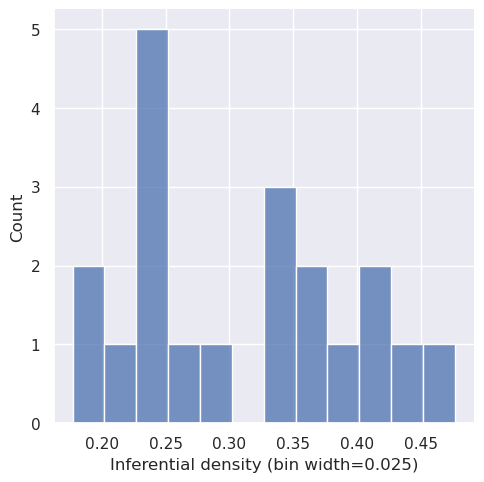

In [9]:
#re_data.drop_duplicates(["ds", "ds_infer_dens"])
g = sns.displot(re_data.drop_duplicates(["ds"]), x="ds_infer_dens", binwidth=0.025)#, discrete=True) 
g.set_axis_labels(x_var='Inferential density (bin width=0.025)')
g.savefig(path.join(figures_output_dir, 'distr-inf-dens.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'distr-inf-dens.png'), bbox_inches='tight')

### Distribution: mean number of premises

count    20.000000
mean      1.449901
std       0.361058
min       1.000000
25%       1.156250
50%       1.428571
75%       1.723214
max       2.000000
Name: ds, dtype: float64

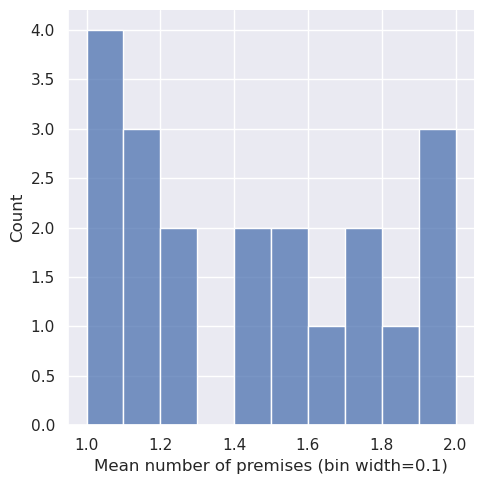

In [10]:
from statistics import mean
# WARNING: do not use `literal_eval` on unsave/unknow data
ser_ds = re_data.drop_duplicates(["ds"])["ds"]
ser_ds = ser_ds.apply(lambda x: literal_eval(x))
ser_ds = ser_ds.apply(lambda tau: mean([len(arg)-1 for arg in tau]))
display(ser_ds.describe())
#display(ser_ds)
g = sns.displot(ser_ds, binwidth=0.1)

g.set_axis_labels(x_var='Mean number of premises (bin width=0.1)')
g.savefig(path.join(figures_output_dir, 'mean-number-premises.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'mean-number-premises.png'), bbox_inches='tight')

## Size of initial commitments

In [11]:
re_data.drop_duplicates(["init_coms"])['init_coms_size'].describe()

count    80.00000
mean      4.91250
std       1.49424
min       2.00000
25%       4.00000
50%       5.00000
75%       6.00000
max       9.00000
Name: init_coms_size, dtype: float64

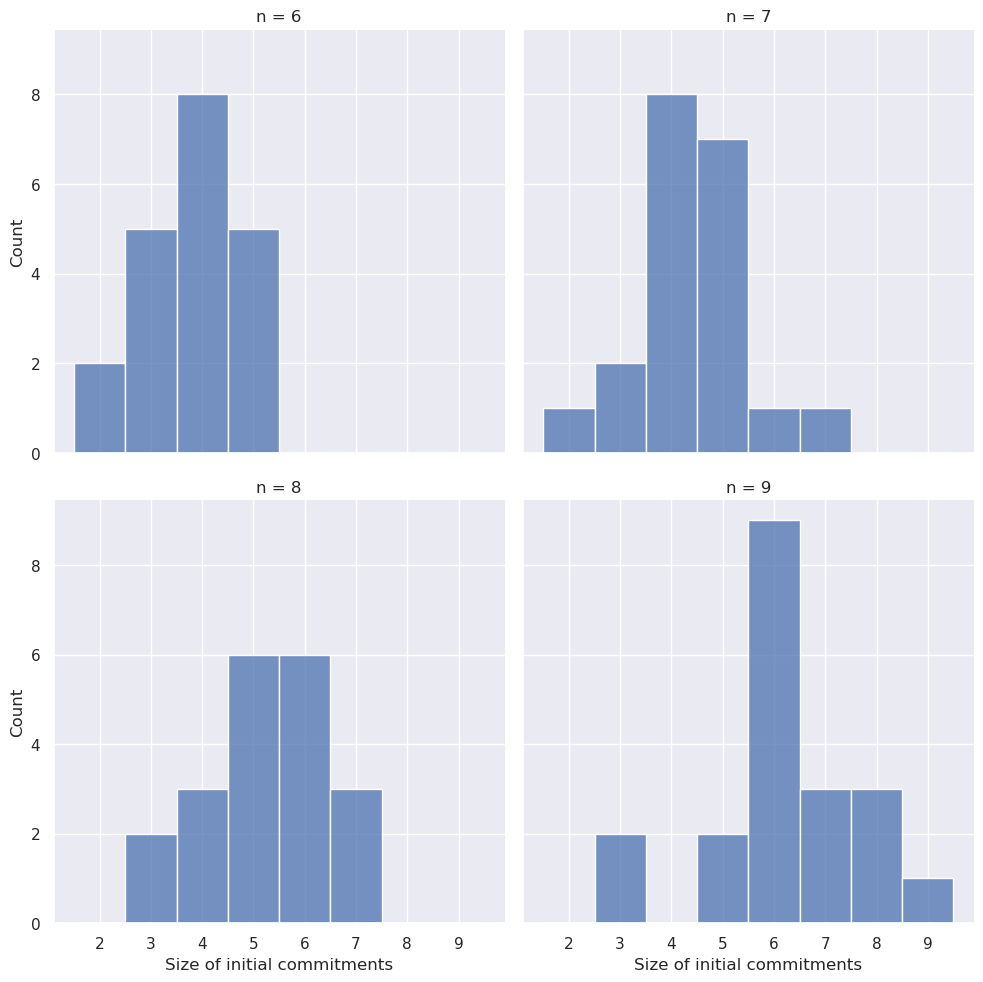

In [12]:
g = sns.displot(re_data.drop_duplicates(['init_coms', 'n_sentence_pool']), x='init_coms_size', 
            col='n_sentence_pool', col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Size of initial commitments')
#g.set_titles(row_template=f'{col_var}')
g.set_titles("n = {col_name}")
g.savefig(path.join(figures_output_dir, 'size-init-coms.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'size-init-coms.png'), bbox_inches='tight')

## Process length

In [13]:
re_data.head()[['coms_evolution', 'process_length']]

,coms_evolution,process_length
0,"[{1, 3, -2, -5}, {1, 3, -6, -5, -4, -2}, {1, 3...",6
1,"[{2, -5, 6}, {2, -5, 6}]",4
2,"[{2, -5, -4, -3}, {2, 6, -5, -4, -3, -1}, {2, ...",6
3,"[{2, -5, -4, -3}, {2, 6, -5, -4, -3, -1}, {2, ...",6
4,"[{5, -4, -3, -1}, {5, 6, -4, -3, -1}, {5, 6, -...",8


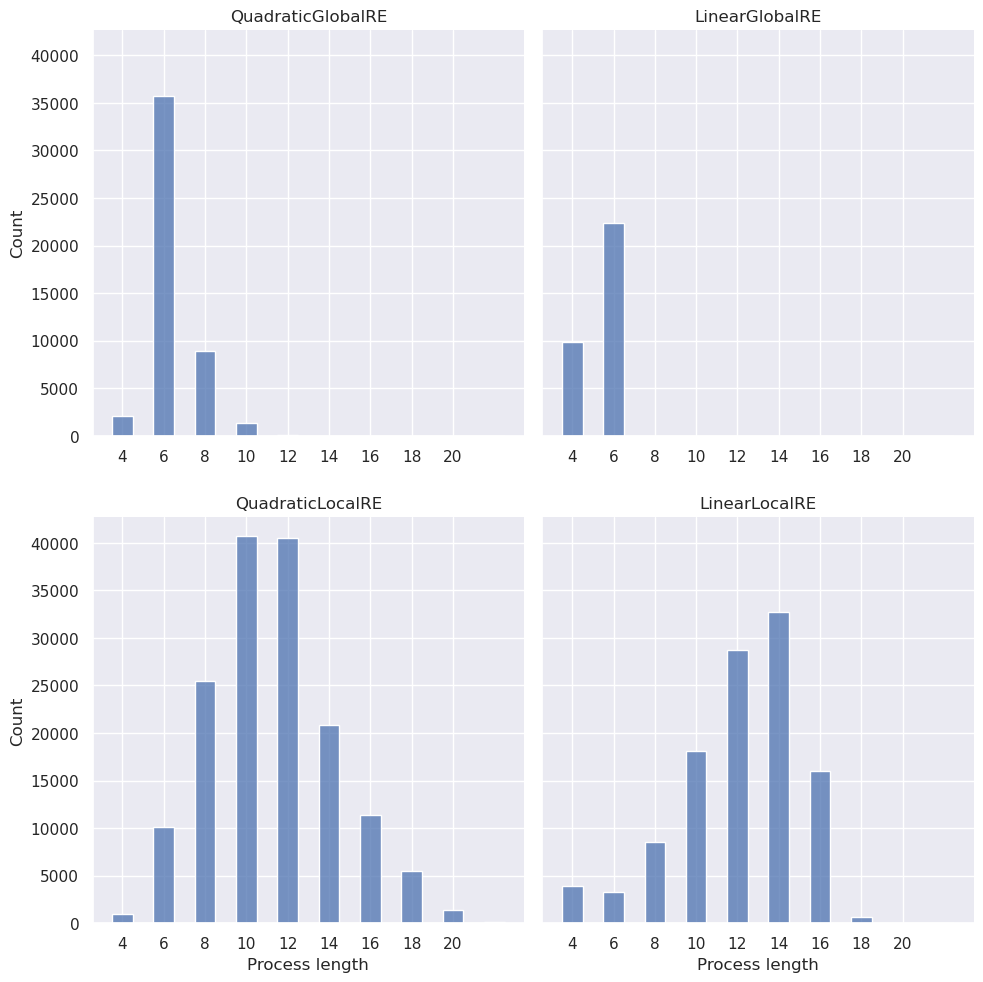

In [14]:
g = sns.displot(re_data, x='process_length', col='model_name', 
                col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Process length')
g.set_titles("{col_name}")
plt.xticks([i*2 for i in range(2,11)])
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.2)

g.savefig(path.join(figures_output_dir, 'dist-process-length.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'dist-process-length.png'), bbox_inches='tight')

Here, we consider all branches.

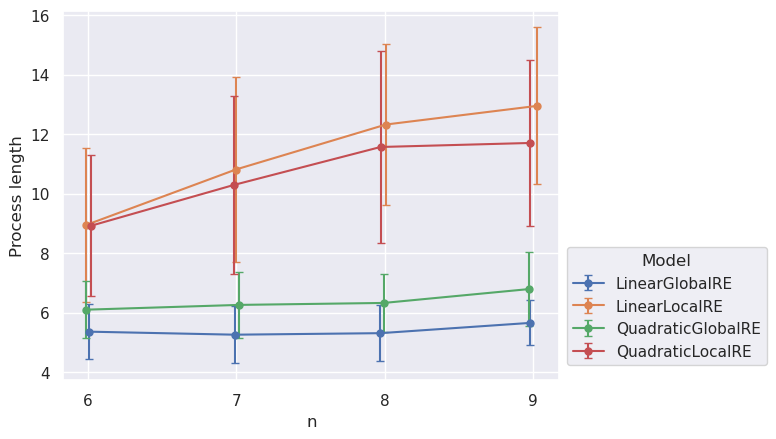

In [15]:
plot_multiple_error_bars(data=re_data, 
                         var_y='process_length', 
                         ylabel='Process length',
                         file_name='process-length', output_dir=figures_output_dir)

## Step length

In [21]:
re_data['mean_step_size_coms'] = re_data.apply(lambda x: mean_simple_hamming_adjacents(list(x['coms_evolution'])[:-1]), axis = 1)

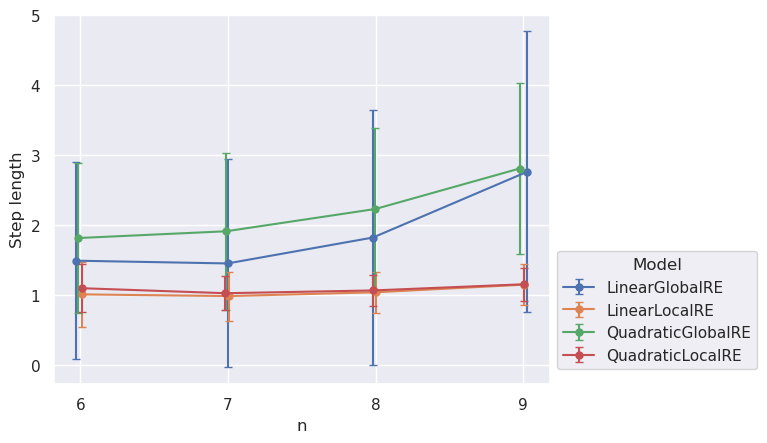

In [22]:
plot_multiple_error_bars(data=re_data, 
                         var_y='mean_step_size_coms', 
                         ylabel='Step length',
                         file_name='step-length', output_dir=figures_output_dir)

## Distance initital and global optima commitments

In [23]:
# mean distance of go commitments to initial commitments
re_data['mean_distance_init_coms_go'] = re_data.apply(mean_d_init_coms_go, axis=1)

In [24]:
# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])

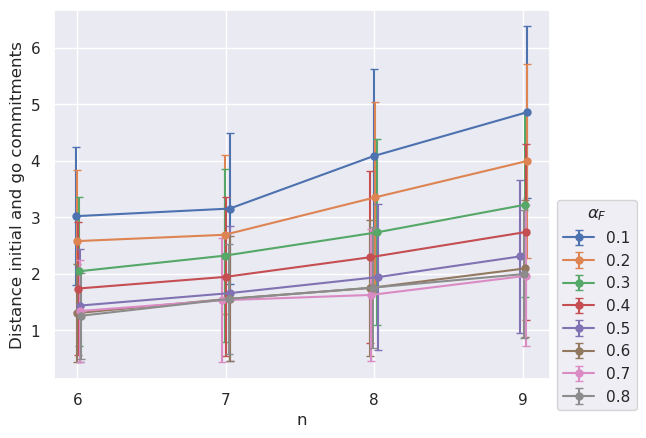

In [25]:
plot_multiple_error_bars(data=re_data_unique_setups, 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Distance initial and go commitments',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name='distance-go-coms',
                         output_dir=figures_output_dir)

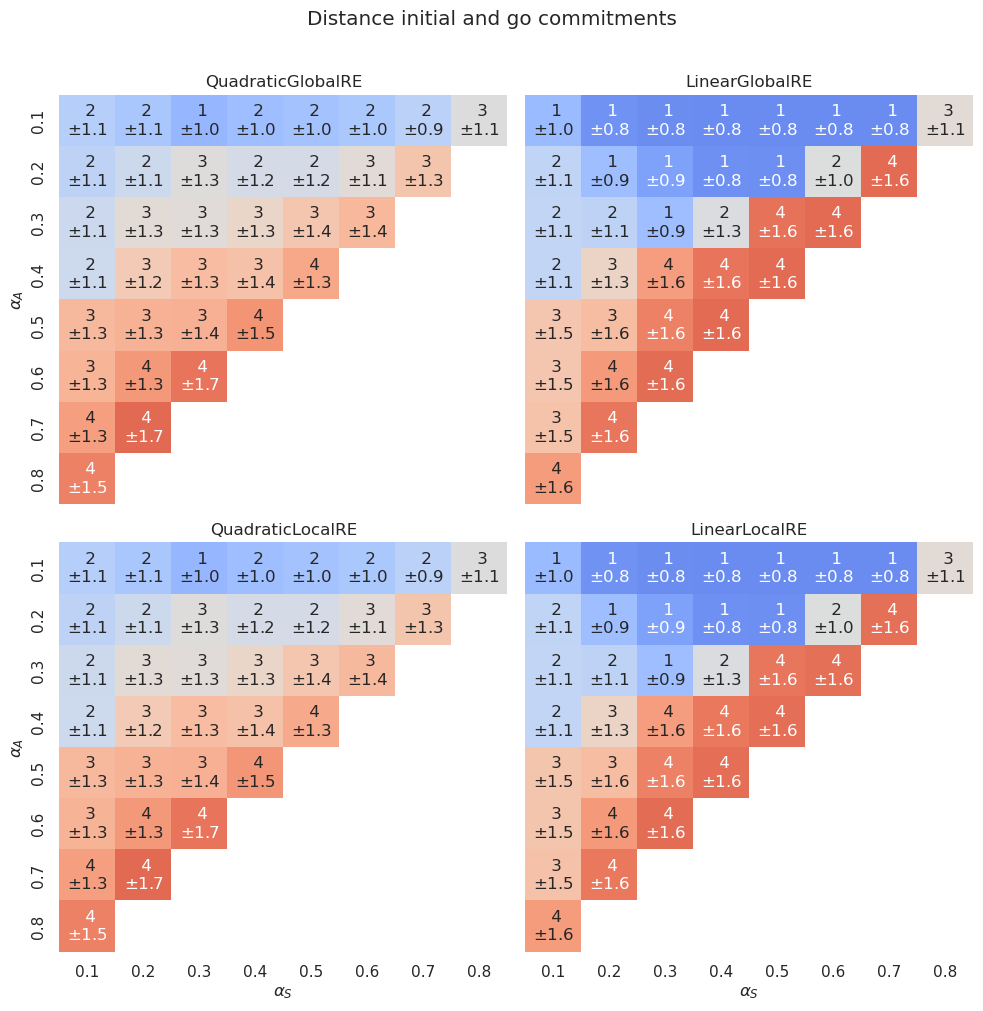

In [26]:
normalized_heat_maps_by_weights(re_data = re_data_unique_setups, 
                                values = 'mean_distance_init_coms_go', 
                                title = 'Distance initial and go commitments', 
                                annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                                vmin=0, vmax=5)

## Counting branches

In [18]:
# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name', 'model_short_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness', 'n_sentence_pool'] 
#cols_group_branches = ['model_name', 'model_short_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness'] 

# Calculating the number of branches for each model run
df_branches = DataFrame({'n_branches' : re_data.groupby(cols_group_branches).size()}).reset_index()

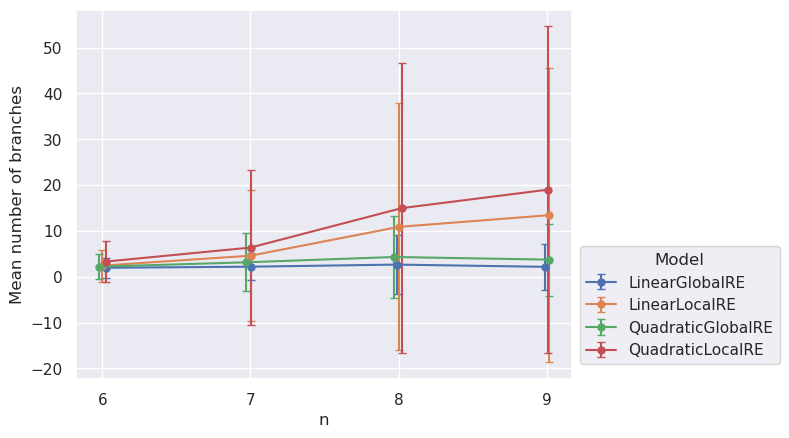

In [19]:
plot_multiple_error_bars(data=df_branches, 
                         var_y='n_branches', 
                         ylabel='Mean number of branches',
                         file_name='mean-branches', output_dir=figures_output_dir)

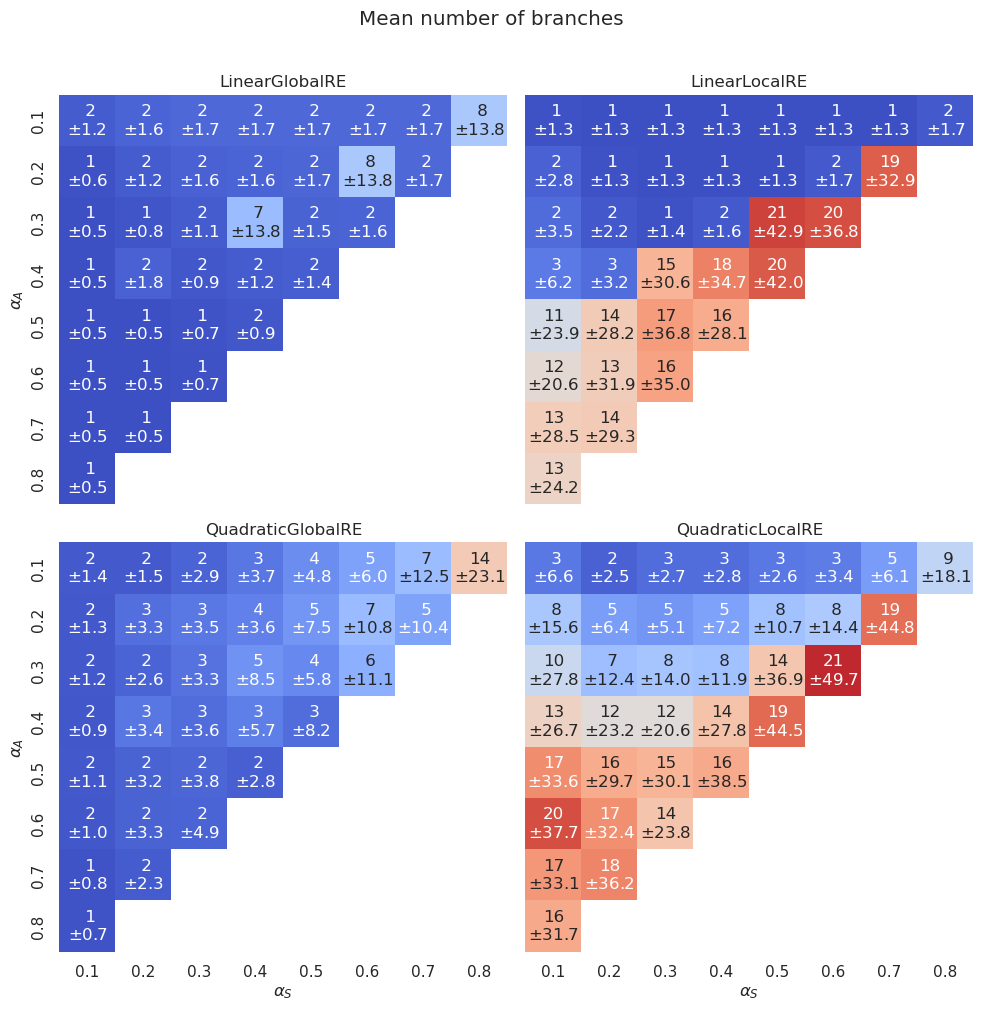

In [27]:
normalized_heat_maps_by_weights(re_data = df_branches, values = 'n_branches', 
                         title = 'Mean number of branches', 
                         annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=22,
                         file_name='hm-mean-branches', output_dir=figures_output_dir)